
![](https://hsto.org/files/256/a5d/ed0/256a5ded03274e0f87ccf97164c31c35.png)


# Регрессия - моя профессия


Задача, где надо спрогнозировать непрерывную переменную называется регрессией. Пример непрерывной переменной: цена на квартиры. Именно её прогнозированием мы сегодня и займёмся. Поехали!


## 1. Предобработка данных 

Начнём наш крестовый поход за дешёвой недвижимостью с предобработки данных. 

In [1]:
import pandas as pd               
import numpy as np                
import matplotlib.pyplot as plt   
import seaborn as sns             

plt.rcParams["figure.figsize"] = [14, 8]
%config Completer.use_jedi = False
%matplotlib inline

# import warnings
# warnings.filterwarnings("ignore")

print("Imports Done!")

Imports Done!


In [2]:
df = pd.read_csv('~/PycharmProjects/Datasets/flat.csv', sep='\t', index_col='n') 
print('Размер выборки:', df.shape)                         
df.head() 

Размер выборки: (2040, 10)


,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
n,,,,,,,,,,
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3


__Описание переменных:__

```
n – номер квартиры по порядку
price – цена квартиры в $1000
totsp – общая площадь квартиры, кв.м.
livesp жилая площадь квартиры, кв.м.
kitsp – площадь кухни, кв.м.
dist – расстояние от центра в км.
metrdist – расстояние до метро в минутах
walk – 1 – пешком от метро, 0 – на транспорте
brick 1 – кирпичный, монолит ж/б, 0 – другой
floor 1 – этаж кроме первого и последнего, 0 – иначе.
code – число от 1 до 8, при помощи которого мы группируем наблюдения по
подвыборкам:
1. Наблюдения сгруппированы на севере, вокруг Калужско-Рижской линии
метрополитена
2. Север, вокруг Серпуховско-Тимирязевской линии метрополитена
3. Северо-запад, вокруг Замоскворецкой линии метрополитена
4. Северо-запад, вокруг Таганско-Краснопресненской линии метрополитена
5. Юго-восток, вокруг Люблинской линии метрополитена
6. Юго-восток, вокруг Таганско-Краснопресненской линии метрополитена
7. Восток, вокруг Калиниской линии метрополитена
8. Восток, вокруг Арбатско-Покровской линии метрополитена
```

In [3]:
df.info() # Посмотрим на информацию по типам переменных 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 1 to 2040
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     2040 non-null   int64  
 1   totsp     2040 non-null   int64  
 2   livesp    2040 non-null   int64  
 3   kitsp     2040 non-null   float64
 4   dist      2040 non-null   float64
 5   metrdist  2040 non-null   int64  
 6   walk      2040 non-null   int64  
 7   brick     2040 non-null   int64  
 8   floor     2040 non-null   int64  
 9   code      2040 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 175.3 KB


In [4]:
df.isnull().sum()  # посмотрим на то есть ли в переменных пропуски

price       0
totsp       0
livesp      0
kitsp       0
dist        0
metrdist    0
walk        0
brick       0
floor       0
code        0
dtype: int64

Пропусков нет. Это хорошая новость. Посмотрим как выглядит распределение цен. 

<AxesSubplot:xlabel='price', ylabel='Count'>

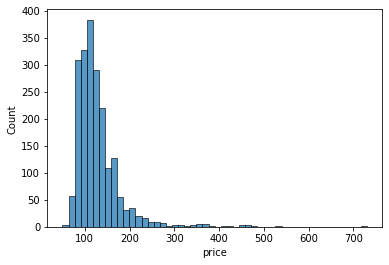

In [5]:
# df.price.hist(bins=30);
sns.histplot(df.price, bins=50)

У распределения цен есть проблема - очень длинный хвост. Такой вид распределения называется логнормальным, поскольку если его прологарифмировато, то оно станет похоже на нормальное. 

Пути борьбы с выбросами: 

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

https://medium.com/swlh/identify-outliers-with-pandas-statsmodels-and-seaborn-2766103bf67c

https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

<AxesSubplot:ylabel='price'>

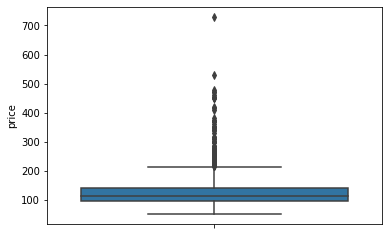

In [6]:
sns.boxplot(data=df, y=df['price'])

Исходя из графика видно - у нас очень много выбросов. 

В выборке встречаются квартиры с довольно большой стоимостью. Такие наблюдения называются выбросами. С ними нужно бороться, иначе наша модель подстроится под них, а это плохо. Проще говоря - модель переобучится. Сгладим распределение цен, прологарифмировав его. Так довольно часто поступают с целевой переменной. 

In [7]:
df['price'] = np.log(df['price'])

<AxesSubplot:xlabel='price', ylabel='Count'>

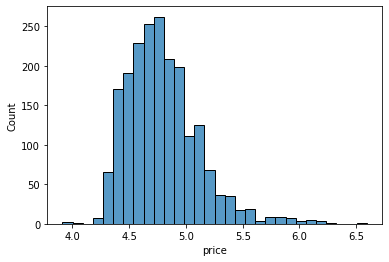

In [8]:
sns.histplot(df.price, bins=30)

<AxesSubplot:ylabel='price'>

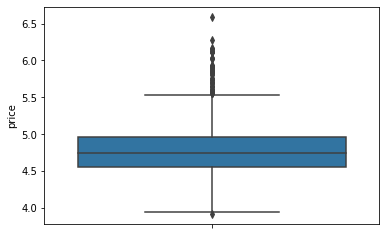

In [9]:
sns.boxplot(data=df, y=df['price'])

Посмотрим на рспределение всех остальных признаков.

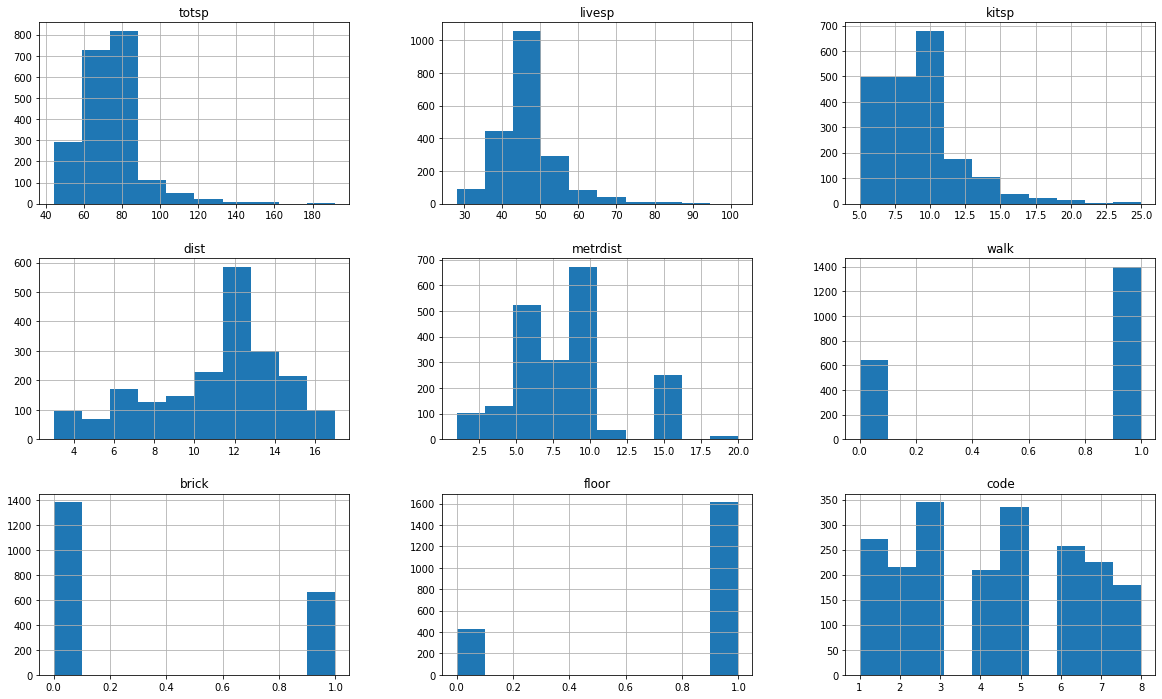

In [10]:
df.drop('price',axis=1).hist(figsize=(20, 12));

Выбросов в остальных данных не так уж и много. Значит можно использовать линейную регрессию. 

Кроме гистограммок имеет смысл взглянуть на матрицу корреляций. 

<AxesSubplot:>

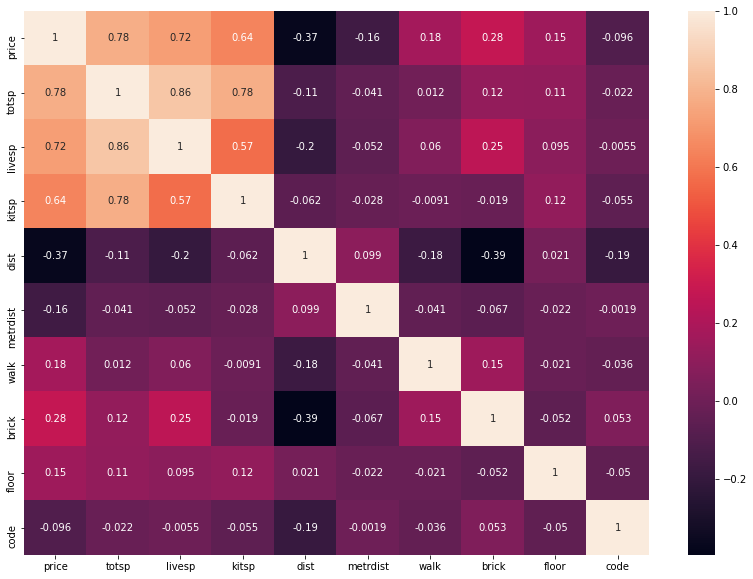

In [11]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True)

<AxesSubplot:>

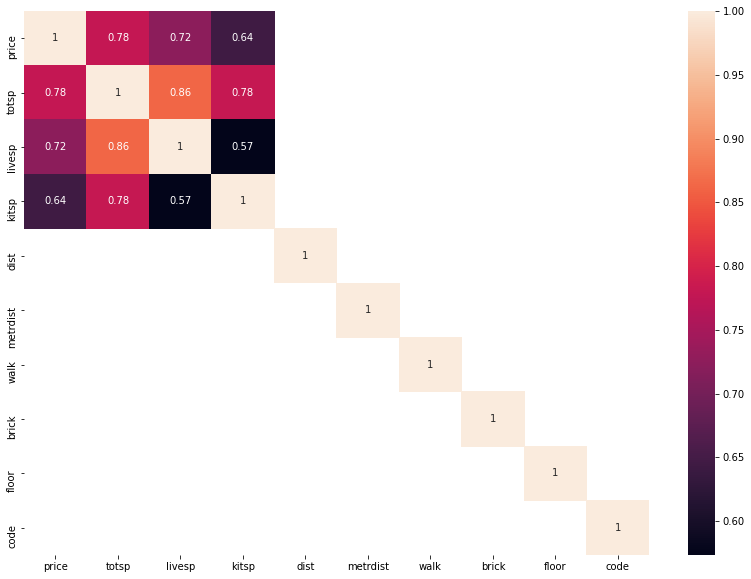

In [12]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr()[abs(df.corr()) > 0.5], annot=True)

In [13]:
from scipy import stats

cols = ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist', 'walk',
       'brick', 'floor', 'code']

for col in cols: 
    pearson_coef, p_value = stats.pearsonr(df[col], df['price'])
    print("PearsonR между {} и price {} с p-значением pvalue = {}".format(col, pearson_coef, p_value ))
    
    if p_value < 0.001:
        print('Корреляция между {} и price статистически значимая'.format(col))
    elif p_value < 0.05:
        print('Корреляция между {} и price средняя'.format(col))
    elif p_value < 0.1:
        print('Корреляция между {} и price слабая'.format(col))
    else:
        print('Корреляция между {} и price статистически незначимая'.format(col))
        
    if pearson_coef > 0 :
        if pearson_coef > 0.85:
            print('Коэффициент ~{} показывает положительную очень сильную связь\n'.format(pearson_coef))
        elif pearson_coef > 0.75 :
            print('Коэффициент ~{} показывает положительную достаточно сильную связь\n'.format(pearson_coef))
        elif pearson_coef > 0.60:
            print('Коэффициент ~{} показывает положительную относительно сильную связь\n'.format(pearson_coef))
        elif pearson_coef > 0.50 :
            print('Коэффициент ~{} показывает положительную среднюю связь\n'.format(pearson_coef))
        else:
            print('Коэффициент ~{} показывает положительную слабую связь\n'.format(pearson_coef))
    else:
        if abs(pearson_coef) > 0.85:
            print('Коэффициент ~{} показывает негативную очень сильную связь\n'.format(pearson_coef))
        elif abs(pearson_coef) > 0.75 :
            print('Коэффициент ~{} показывает негативную достаточно сильную связь\n'.format(pearson_coef))
        elif abs(pearson_coef) > 0.60:
            print('Коэффициент ~{} показывает негативную относительно сильную связь\n'.format(pearson_coef))
        elif abs(pearson_coef) > 0.50 :
            print('Коэффициент ~{} показывает негативную среднюю связь\n'.format(pearson_coef))
        else:
            print('Коэффициент ~{} показывает негативную слабую связь\n'.format(pearson_coef))

PearsonR между totsp и price 0.7785888467414172 с p-значением pvalue = 0.0
Корреляция между totsp и price статистически значимая
Коэффициент ~0.7785888467414172 показывает положительную достаточно сильную связь

PearsonR между livesp и price 0.7237282409187379 с p-значением pvalue = 0.0
Корреляция между livesp и price статистически значимая
Коэффициент ~0.7237282409187379 показывает положительную относительно сильную связь

PearsonR между kitsp и price 0.6449846180601011 с p-значением pvalue = 2.559881638041084e-240
Корреляция между kitsp и price статистически значимая
Коэффициент ~0.6449846180601011 показывает положительную относительно сильную связь

PearsonR между dist и price -0.370190088521427 с p-значением pvalue = 2.8291635836219835e-67
Корреляция между dist и price статистически значимая
Коэффициент ~-0.370190088521427 показывает негативную слабую связь

PearsonR между metrdist и price -0.1588438868465477 с p-значением pvalue = 5.359389941926129e-13
Корреляция между metrdist и 

Чисто логически переменные metrdist и walk должны коррелировать, однако по расчётам этого не происходит. 

Для более адекватной оценки стоило бы группировать датасет по переменной walk, однако из-за того что ЛР является интерпертируемой моделью, то из результатов работы модели эти зависимости можно будет получить в явном виде. 

Дополнительно посмотрим на попарные диаграммы рассеивания.

In [14]:
# sns.pairplot(df)

Теперь распределение выглядит более приятно. 

Займёмся предобработкой категориальных переменных при помощи одного горячего кодирования (One Hot Encoding) (кек). При таком преобразовании категориальной переменной мы создаем столько новых столбцов, сколько различных значений этой переменной у нас было. Обычно, при этом, первый столбец убирается, чтобы не создавать линейно-зависимых столбцов. Например, если у переменной `"погода"` есть три состояния `"хорошая"`, `"средняя"` и `"нормальная"`, то после `OneHotEncoding` мы получим три столбца, где значения будут либо нулями, либо единицами, в зависимости от того, какая погода была в этом наблюдении.

## Важно
`OneHotEncoding` в общем случае тоже может привнести информацию о тестовой выборке в тренировочную в том случае, если в категориальном столбце в отложенной выборке могут содержаться новые значения. Если такая вероятность есть, то как и с другими методами препроцессинга, `OneHotEncoding` нужно обучать на трейне и использовать на тесте. 

В остальных случаях, можно воспользоваться удобной оберткой в `pandas` - `pd.get_dummies()`

In [15]:
# Чтобы не произошло утечки данных из трейна в тест, то стоит использовать OHE из sklearn'а.

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# .fit на трейне, .transform на тесте!
# .fit(train), .transform(test)

In [16]:
# Сделали OHE для категориальной переменной
df_categor = pd.get_dummies(df['code'], drop_first=True, prefix='code')
# drop_first=True используется для того, чтобы избежать идеальной мультеколлинеарности в данных
# Следовательно - использовать обязательно!

# Объединили назад наши таблички
df = pd.concat([df.drop('code',axis=1), df_categor], axis=1)
df.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code_2,code_3,code_4,code_5,code_6,code_7,code_8
n,,,,,,,,,,,,,,,,
1,4.394449,58,40,6.0,12.5,7,1,1,1,0,1,0,0,0,0,0
2,4.317488,44,28,6.0,13.5,7,1,0,1,0,0,0,0,1,0,0
3,4.852030,70,42,6.0,14.5,3,1,1,1,0,1,0,0,0,0,0
4,4.553877,61,37,6.0,13.5,7,1,0,1,0,0,0,0,0,0,0
5,5.799093,104,60,11.0,10.5,7,0,1,1,0,1,0,0,0,0,0


Делим данные на тренировочные и тестовые! $30\%$ данных откладываем для тестирования качества модели. Остальные $70\%$ берём для обучения. 

In [17]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.3)

Последний предобрабатывательский штрих это скалирование (стандартизация непрерывных переменных). Вспомним зачем его делают. Обычно, когда обучают модель, хотят минимизировать ошибку, которую она допускает. Чаще всего эту функцию минимизируют численно. Если переменные измерены в разных шкалах (что-то в тоннах, что-то в годах и тд), алгоритм может при обучении заблудиться. Хорошо бы направить его и подтолкнуть в нужном направлении. Таким толчком является стандартизация переменных. 

Из каждой переменной вычетают среднее и делят на стандартное отклонение. Это очищает переменные от своих уникальных шкал и упрощает путь алгоритма к оптимальной точке. Обычно стандартное отклонение и среднее для скалирования оценивают на обучающей выборке. К тестовой применяют уже оценённый результат. Это позволяет не подглядывать в тестовую часть и не улучшать за счёт этого подглядывания прогнозы. Подглядывать - нечестно! 

Стандартизация нужна и для корректного применения регуляризации в линейной регрессии, иначе будут большие штрафы за коэффициенты, а это ухудшает качество модели.

In [18]:
from sklearn.preprocessing import StandardScaler

# объявили скалировщик!
scaler = StandardScaler()

# учим скалировщик скалировать все переменны на трэйне
scaler.fit(df_train.loc[:, ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']]) 

StandardScaler()

In [19]:
# Применяем скалировщик к трэйну
df_train_scale = scaler.transform(df_train.loc[:, ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']])

# Применяем скалирвощик к тесту 
df_test_scale = scaler.transform(df_test.loc[:, ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']])

In [20]:
# Заменяем значения на отскалированные
df_train.loc[:, ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']] = df_train_scale
df_test.loc[:, ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']] = df_test_scale

/home/aleksey/PycharmProjects/Machine_Learning_test_area/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Все непрерывные переменные теперь выглядят проскалированными =) 

In [21]:
df_train.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code_2,code_3,code_4,code_5,code_6,code_7,code_8
n,,,,,,,,,,,,,,,,
697,4.634729,0.218101,-0.170248,0.416444,0.605885,-0.801808,0,0,1,0,0,0,1,0,0,0
1511,4.867534,0.702684,-0.038977,0.416444,-0.146205,-1.850086,1,0,1,0,0,0,0,0,1,0
508,4.430817,-0.958743,-0.038977,-1.043794,-0.296622,1.818888,1,0,1,0,0,0,0,1,0,0
143,4.595120,0.218101,-0.170248,0.416444,0.305049,0.508540,1,0,1,0,0,0,1,0,0,0
695,4.682131,-1.027969,-0.695334,-1.043794,-0.597458,-1.325947,1,1,1,0,0,1,0,0,0,0


In [22]:
print(df_train.shape) # Посмотрим на размеры трэйна и теста 
print(df_test.shape)  

(1428, 16)
(612, 16)


In [23]:
# Вытаскиваем цены и параметры квартир по разным переменным для удобства 

y_train = df_train.price 
y_test = df_test.price 

X_train = df_train.drop('price', axis=1).to_numpy()
X_test = df_test.drop('price', axis=1).to_numpy()

## 2. Константный прогноз 

Шаг первый. Построим константный прогноз. Будем говорить, что стоимость любой квартиры равна среднему значению. Это самый глупый прогноз, который мы можем сделать. Мы будем сравнивать с ним прогнозы более сложных моделей. Это бейзлайн-модель (baseline). Иногда, когда данные очень шумные, то она может быть лучше других моделей. Но это редкий вариант.

In [24]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им цену всех квартир в тестовой выборке
y_pred_naive[:5]

array([4.78326734, 4.78326734, 4.78326734, 4.78326734, 4.78326734])

In [25]:
np.exp(y_pred_naive[:5]) # стоимости квартир в тыс. $

array([119.49414033, 119.49414033, 119.49414033, 119.49414033,
       119.49414033])

## 3. Метрики качества для регрессии 

Мы сделали выше прогноз. Теперь мы хотим понять насколько он хороший. Для этого обычно используют метрики. Посмотрим на несколько таких метрик. 

In [26]:
from sklearn import metrics  # подгружаем метрики

Первой метрикой, с которой мы познакомимся, будет MAE (mean absolute error), средняя абсолютная ошибка. Она вычисляется следующим образом: 

$$ MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|. $$

Если мы спрогнозировали, что квартира стоит 20 рублей, а она стоила 10 рублей, мы ошиблись на |10 - 20| = 10 рублей. Средняя абсолютная ошибка - это средняя сумма рублей, на которую мы облажались. 

In [27]:
metrics.mean_absolute_error(y_test, y_pred_naive)

0.2520438510641494

Напомню, что мы прогнозируем логарифм цены, нам так удобнее. Ошибка выше считается в логарифмах. Если мы хотим посмотреть на ошибку в долларах, надо взять экспоненту от цен. Ниже мы можем увидеть, что в среднем ошибаемся на тридцать три с лишним тысячи долларов. (зависит от того как разобьётся датасет на тестовую и трейновую выборки)

In [28]:
metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred_naive))

35.49302361940024

Второй метрикой является MSE (mean squared error), средняя квадратичная ошибка. Она вычисляется как 

$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2.$$

Смысл этой ошибки в том, чтобы штрафовать за большие ошибки сильнее, чем за маленькие. Если мы ошиблись на 5 долларов, то в ошибку войдёт 25. Если мы ошиблись на 10 долларов, то в ошибку войдёт 100. Чем выше ошибка, тем сильнее штраф. 

In [29]:
metrics.mean_squared_error(y_test, y_pred_naive)

0.11829301268815905

По аналогии перейдём к долларам. 

In [30]:
metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred_naive))

4103.471338307108

Получилось многовато! Всё дело в том, что это не просто доллары, это квадратные доллары. Мы же суммировали квадраты. Неплохо было бы вернутся к обычным долларам. Для этого надо взять из MSE квадратный корень. Тогда получится новая ошибка, RMSE - Root Mean Squared Error. 

In [31]:
np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred_naive)))

64.05834323729508

Ошибка в среднем более чем на 57 тысяч долларов. Так как более большие ошибки входят с более большим весом, вполне логично, что RMSE получилось больше, чем MAE. 

Часто для нас принципиальным является не то, на сколько денег мы ошиблись, а то на сколько процентов мы ошиблись. Метрика, которая отлавливает процентную ошибку, называется MAPE (mean absolute percentage error), средняя абсолютная процентная ошибка. 

$$
MAPE = \frac{1}{n} \sum_{i=1}^n \frac{|y_i - \hat{y}_i|}{y_i}
$$

Она часто применяется в следующих задачах: например, вы прогнозируете спрос, и вам принципиально, на сколько процентов вы ошиблись, а не абсолютное значение. Если вы предсказали  один, а в реальности было  десять - это не то же самое, что вы предсказали  тысяча, а в реальности было  тысяча  девять. С точки зрения МАЕ или MSE, это две совершенно одинаковые ошибки. А если вас интересует, сколько в среднем на сколько процентов вы ошибаетесь, то это отражает МАРЕ.

Её нам придётся реальзовать самостоятельно. Благо, это не очень трудно. 

In [32]:
def my_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

my_mean_absolute_percentage_error(y_test, y_pred_naive)

5.11503271424651

In [33]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, y_pred_naive) * 100

5.11503271424651

Средняя ошибка примерно на $5\%$ от цены. 

Последняя метрика, с которой нам нужно познакомиться, это коэффициент детерминации, $R^2$. Он отражает то, какую долю дисперсии объясняемой переменной мы объяснили с помощью нашей модели:

$$ R^2 =1- \frac{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \bar{y}_i)^2} $$

Эту метрику очень сильно любят консалтеры и аудиторы, потому что только её они и знают. На самом деле в ней нет ничего хорошего. При добавлении в модель новых переменных она всегда растёт. У неё есть ещё несколько тонких математических недостатков, о которых вы можете узнать из книг. 

In [34]:
metrics.r2_score(y_test, y_pred_naive)

-0.006212415420700612

Закинем все метрики в одну общую функцию, чтобы было удобно их печатать. 

In [35]:
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred) * 100)
    pass

In [36]:
print_metrics(y_test, y_pred_naive)

MAE: 35.49302361940024
RMSE: 64.05834323729508
R2: -0.006212415420700612
MAPE: 5.11503271424651


## 3. Строим нашу первую регрессию!

Пришло время построить линейную регрессию! Эта модель говорит, что цена на квартиру формируется в результате суммирования тех характеристик, которыми она обладает с какими-то весами

$$\hat{y} = \beta_0 + \beta_1 x_1 + ... \beta_n x_n.$$

Например, если мы оценили модель и у нас получилось, что 

$$ price = 30 000 + 20 000 \cdot totsp,$$

то это означает, что средняя стоимость квартиры равна 30 тыс. долларам. При этом каждый дополнительный метр общей площади квартиры делает её дороже на 20 тысяч долларов. 

Для того, чтобы обучить регрессию минимизируют одну из метрик, перечисленных в прошлом разделе. В базовой комплектации регрессии это делают с MSE. Такая модель обладает огромным количеством няшных статистических свойств. 

In [37]:
from sklearn.linear_model import LinearRegression

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

Посмотрим на качество прогнозов. Мы стали ошибаться меньше, чем раньше. 

In [38]:
print_metrics(y_test,y_pred_regr)

MAE: 17.212539895984513
RMSE: 34.07077262547284
R2: 0.7911981280358868
MAPE: 2.2793924354223534


In [39]:
model_regression.intercept_, model_regression.coef_

(4.717774363307614,
 array([ 0.16259889,  0.01472815,  0.05110919, -0.06563132, -0.03576416,
         0.08653065,  0.02595267,  0.06535042, -0.04090857,  0.03578209,
        -0.01113836, -0.1551936 , -0.13581141, -0.0924482 , -0.01844203]))

Посмотрим на то, какие признаки вносят в цену наибольший вклад. 

<AxesSubplot:xlabel='feature', ylabel='importance'>

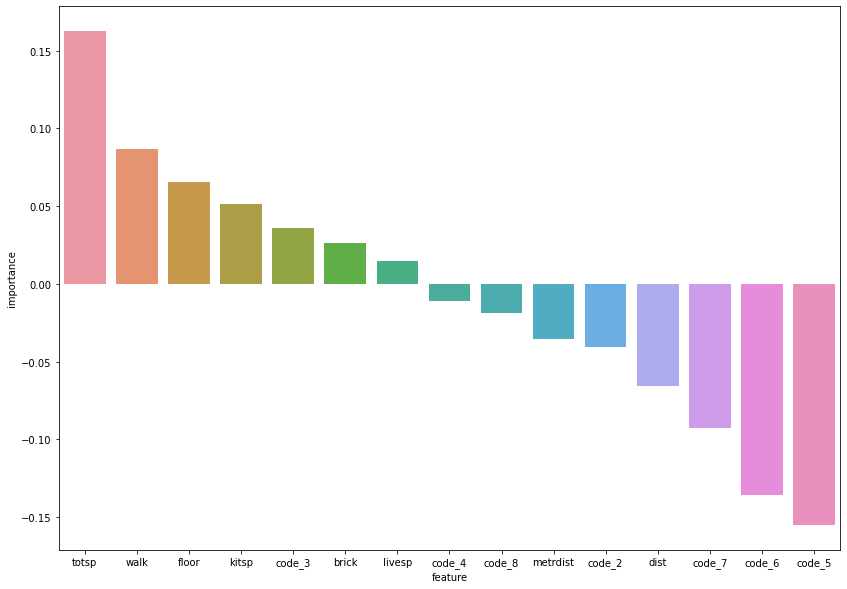

In [40]:
feature_importance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_regression.coef_})

feature_importance.set_index('feature', inplace=True)
feature_importance.sort_values(["importance"], ascending=False, inplace=True)
plt.figure(figsize=(14, 10))
sns.barplot(data=feature_importance, y="importance", x=feature_importance.index)

## 4. Строим Lasso-регрессию 

Построим более сложную модель, LASSO-регрейссию. Фишка этой модели в том, что она зануляет лишние коэффиценты. 

In [41]:
from sklearn.linear_model import Lasso

# Объявили модель
model_simplelasso = Lasso()

# Обучили модель на тренировочной выборке 
model_simplelasso.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_lasso = model_simplelasso.predict(X_test)

Посмотрим на важность факторов для стоимости квартиры. 

<AxesSubplot:xlabel='feature', ylabel='importance'>

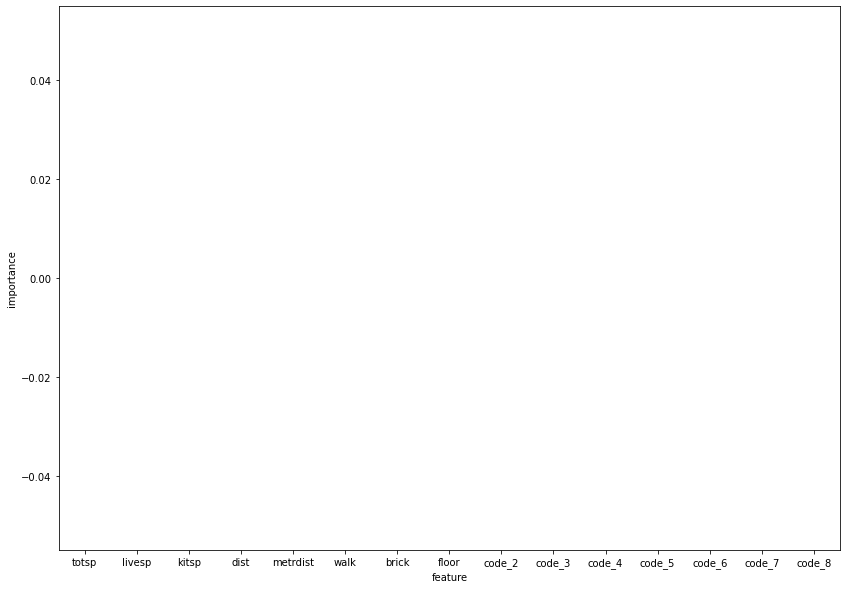

In [42]:
feature_importance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_simplelasso.coef_})

feature_importance.set_index('feature', inplace=True)
feature_importance.sort_values(["importance"], ascending=False, inplace=True)
plt.figure(figsize=(14, 10))
sns.barplot(data=feature_importance, y="importance", x=feature_importance.index)

In [43]:
print_metrics(y_test,y_pred_lasso)

MAE: 35.49302361940024
RMSE: 64.05834323729508
R2: -0.006212415420700612
MAPE: 5.11503271424651


Важных факторов нет, всё занулилось. Метрики качества такие же, как при константном прогнозе. Почему такое произошло? Дело в том, что у модели есть гиперпараметр - сила зануления. И его нужно подбирать методом перебора. В нашей модели он стоял слишком большим. Давайте попробуем подобрать этот параметр. 

## 5. Подбор гиперпараметра для Lasso-регрессии

Будем делать перебор следующим способом: дробим тренировочную выборку на пять частей. На четырёх учим модель, на пятой прогнозируем. Смотрим на качество. И так по очереди выделяем для прогноза каждую из 5 частичек. Потом качество прогноза усредняем - кросс-валидация. Для какого параметра из решётки качетство получится наибольшим, тот мы и оставим. 

In [44]:
from sklearn.model_selection import GridSearchCV

# Решётака для перебора параметра 
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1]}

# Объявили модель 
model_lasso = Lasso() 

# Объявили перебор 
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(X_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

# Сделали прогнозы
y_pred_lasso = grid_cv_lasso.predict(X_test)

Лучшее значение параметра: {'alpha': 0.001}


При параметре 0.001 качество у прогнозов получилось самым хорошим. Его и берём. Посмотрим на важность переменных

In [45]:
grid_cv_lasso.best_estimator_.intercept_, grid_cv_lasso.best_estimator_.coef_

(4.708611345486913,
 array([ 0.16034199,  0.01727982,  0.05155604, -0.06654564, -0.03453108,
         0.08109668,  0.02301922,  0.06044936, -0.01328569,  0.04684928,
         0.        , -0.13066368, -0.11053782, -0.06647789, -0.        ]))

<AxesSubplot:xlabel='feature', ylabel='importance'>

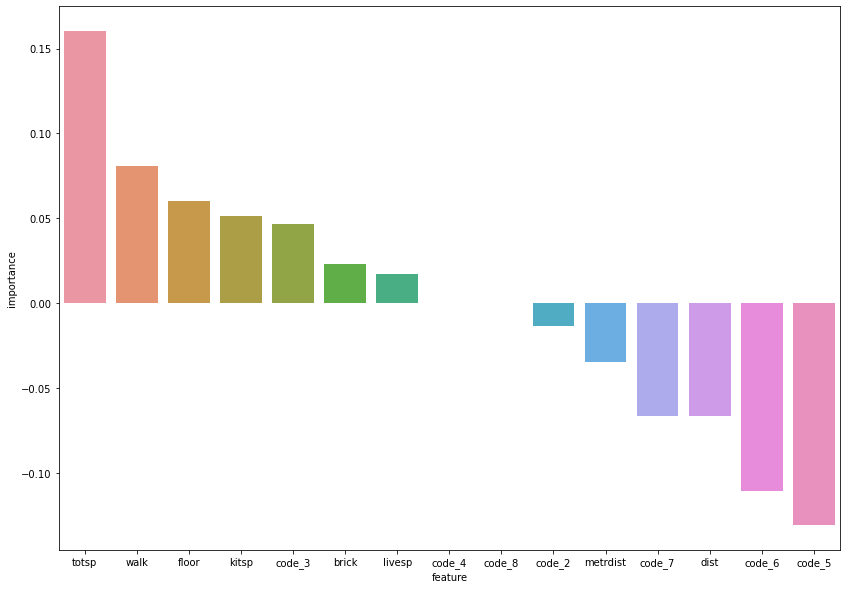

In [46]:
feature_importance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": grid_cv_lasso.best_estimator_.coef_})

feature_importance.set_index('feature', inplace=True)
feature_importance.sort_values(["importance"], ascending=False, inplace=True)
plt.figure(figsize=(14, 10))
sns.barplot(data=feature_importance, y="importance", x=feature_importance.index)

И на качество модели. Оно оказывается близким к обычной регрессии. Судя по всему у нас в выборке нет лишних переменных и занулять нечего. 

In [47]:
# Количество квартир в районах
df[[col for col in df.columns if "code" in col]].sum()

code_2    215
code_3    345
code_4    209
code_5    336
code_6    257
code_7    226
code_8    180
dtype: int64

In [48]:
print_metrics(y_test,y_pred_lasso)

MAE: 17.233026469358382
RMSE: 34.08481251552765
R2: 0.7912091763111524
MAPE: 2.2745593734144847


In [49]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

# Сделали прогнозы
y_pred_lasso_cv = lasso_cv.predict(X_test)

Лучшее значение параметра: 0.00030389498158590064


<AxesSubplot:xlabel='price', ylabel='price'>

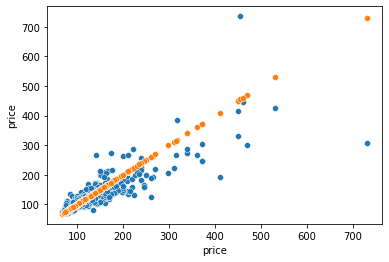

In [90]:
sns.scatterplot(x=np.exp(df_test.iloc[:, 0]), y=np.exp(y_pred_lasso_cv))
sns.scatterplot(x=np.exp(df_test.iloc[:, 0]), y=np.exp(y_test))

<AxesSubplot:xlabel='feature', ylabel='importance'>

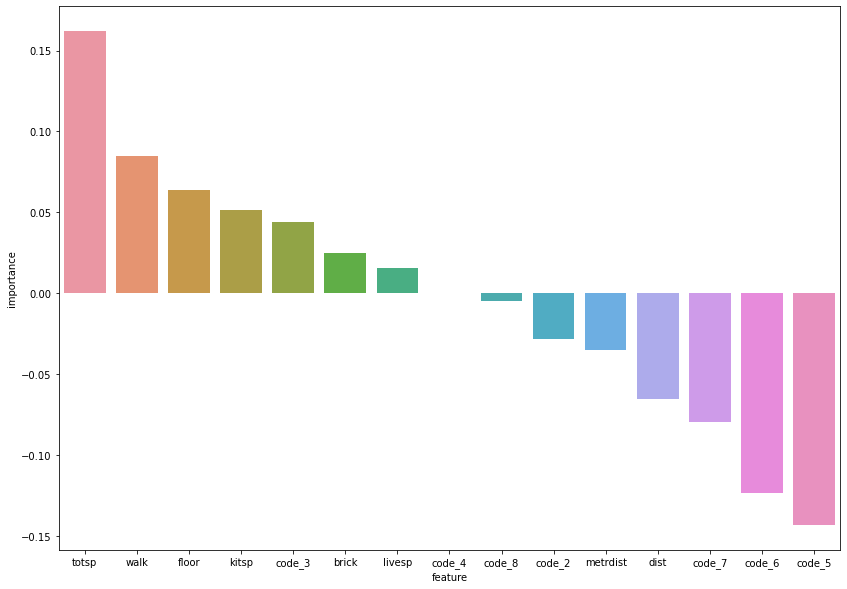

In [51]:
feature_importance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": lasso_cv.coef_})

feature_importance.set_index('feature', inplace=True)
feature_importance.sort_values(["importance"], ascending=False, inplace=True)
plt.figure(figsize=(14, 10))
sns.barplot(data=feature_importance, y="importance", x=feature_importance.index)

In [52]:
print_metrics(y_test, y_pred_lasso_cv)

MAE: 17.189978156964685
RMSE: 34.043084784207394
R2: 0.7915822436970885
MAPE: 2.273018674093745


Важно отметить, что полученные оценки важности предикторов - точечные. По-хорошему, если рассматривать эконометрический подход, то стоит построить доверительные интервалы для предикторов. 

Подходы с точки зрения машинного обучения и эконометрики различаются!